In [1]:
# Install necessary libraries
!pip install yfinance==0.2.37 --quiet
!pip install git+https://github.com/time-series-foundation-models/lag-llama.git
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 2.2 MB/s eta 0:00:00
  Cloning https://github.com/time-series-foundation-models/lag-llama.git to /tmp/pip-req-build-lxzf0h18
  Running command git clone --filter=blob:none --quiet https://github.com/time-series-foundation-models/lag-llama.git /tmp/pip-req-build-lxzf0h18
  Resolved https://github.com/time-series-foundation-models/lag-llama.git to commit 37cce619728f36116fa06efe1b05765655b7e5c7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [2]:

import yfinance as yf
import pandas as pd
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import islice


In [3]:

# Download stock data
stock_prices = (
    yf.Tickers("aapl amd amzn crm goog meta msft nvda tsla")
    .history(period="max", start="2013-01-01")
    .Close
    .resample('1d')
    .ffill()
)

# Smooth prices and compute returns
stock_returns = stock_prices.rolling(5).mean().pct_change().dropna()


[*********************100%%**********************]  9 of 9 completed


In [4]:

# Prepare dataset for Lag-Llama
def _get_lag_llama_dataset(dataset):
    dataset = dataset.copy()
    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(
            dataset[col]
        ):
            dataset[col] = dataset[col].astype("float32")
    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset

backtest_dataset = _get_lag_llama_dataset(dataset=stock_returns)



In [5]:

# Prediction function
def _get_lag_llama_predictions(dataset, prediction_length, num_samples=100, predictor = None):
    ckpt = torch.load("/content/lag-llama/lag-llama.ckpt", map_location=torch.device("cuda:0"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    estimator = LagLlamaEstimator(
        ckpt_path="/content/lag-llama/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        batch_size=1,
        num_parallel_samples=100,
    )
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = (
        predictor
        if predictor is not None
        else estimator.create_predictor(transformation, lightning_module)
    )
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor, num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    return forecasts, tss


<ipython-input-5-568288a4f9c8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/content/lag-llama/lag-llama.ckpt", map_location=torch.device("cuda:0"))
/

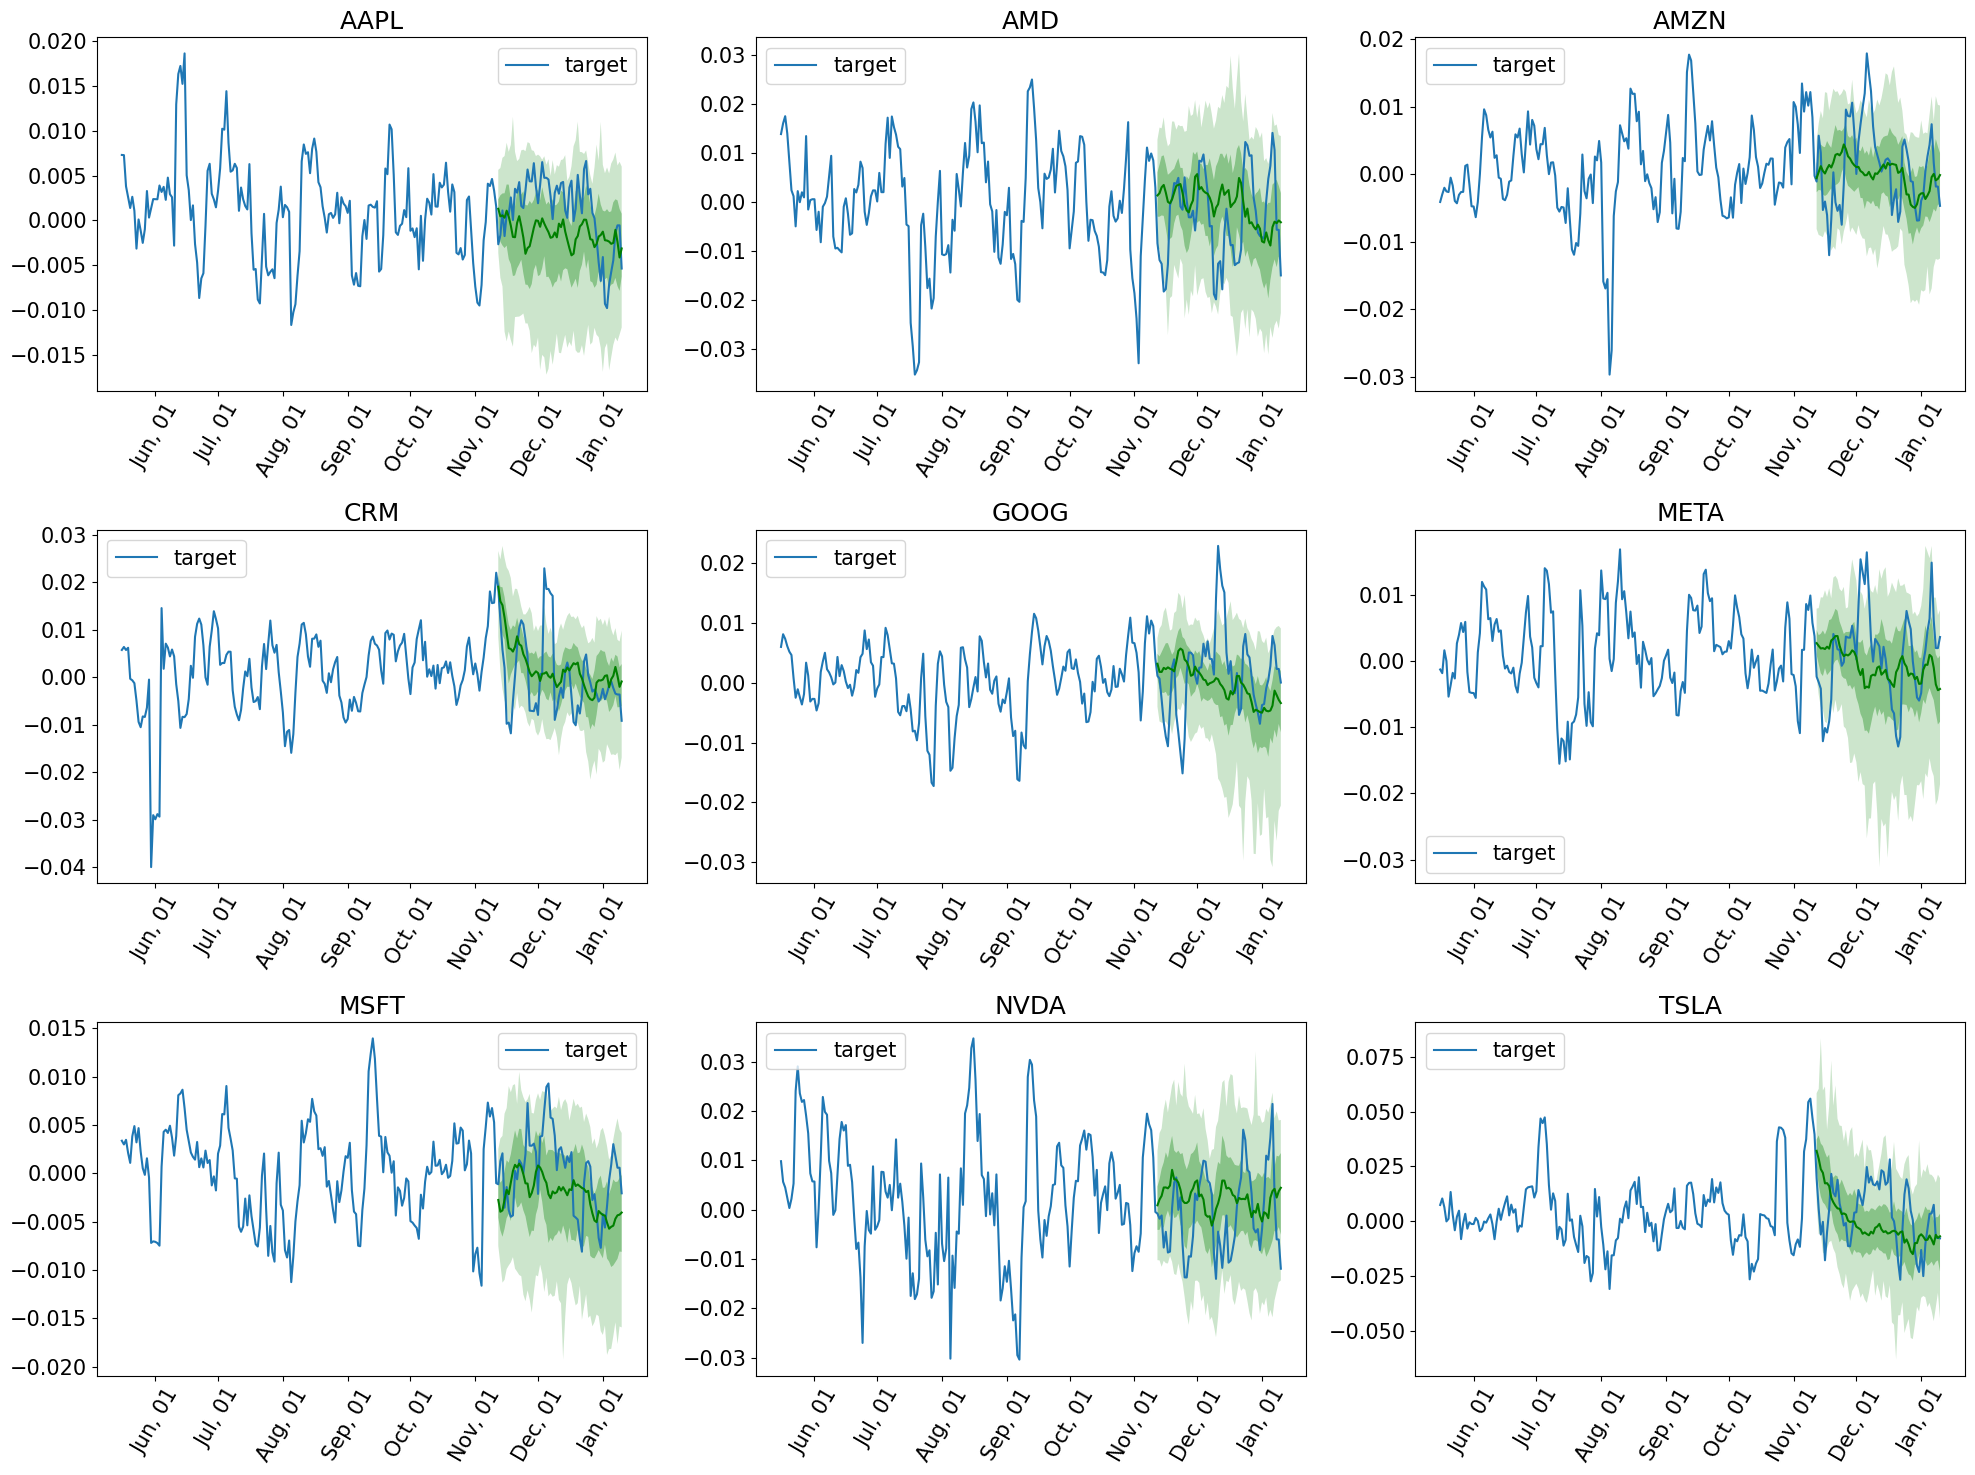

In [6]:

# --- Zero-Shot Inference ---
prediction_length = 60
num_samples = 100
forecasts, tss = _get_lag_llama_predictions(
    backtest_dataset, prediction_length, num_samples
)

# Plotting function
def plot_forecasts(forecasts, tss, prediction_length):
    plt.figure(figsize=(20, 15))
    date_formater = mdates.DateFormatter("%b, %d")
    plt.rcParams.update({"font.size": 15})
    for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
        ax = plt.subplot(3, 3, idx + 1)
        plt.plot(
            ts[(-4 * prediction_length):].to_timestamp(),
            label="target",
        )
        forecast.plot(color="g")
        plt.xticks(rotation=60)
        ax.xaxis.set_major_formatter(date_formater)
        ax.set_title(forecast.item_id)
        plt.gcf().tight_layout()
        plt.legend()
    plt.show()

# Plotting Zero-Shot Forecasts
plot_forecasts(forecasts, tss, prediction_length)



<ipython-input-7-3b66eea18ec3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/content/lag-llama/lag-llama.ckpt", map_location="cuda")
/usr/local/lib/py

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached -4.13731 (best -4.13731), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -4.13731 (best -4.13731), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -4.59793 (best -4.59793), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -4.59793 (best -4.59793), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -5.29203 (best -5.29203), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global s

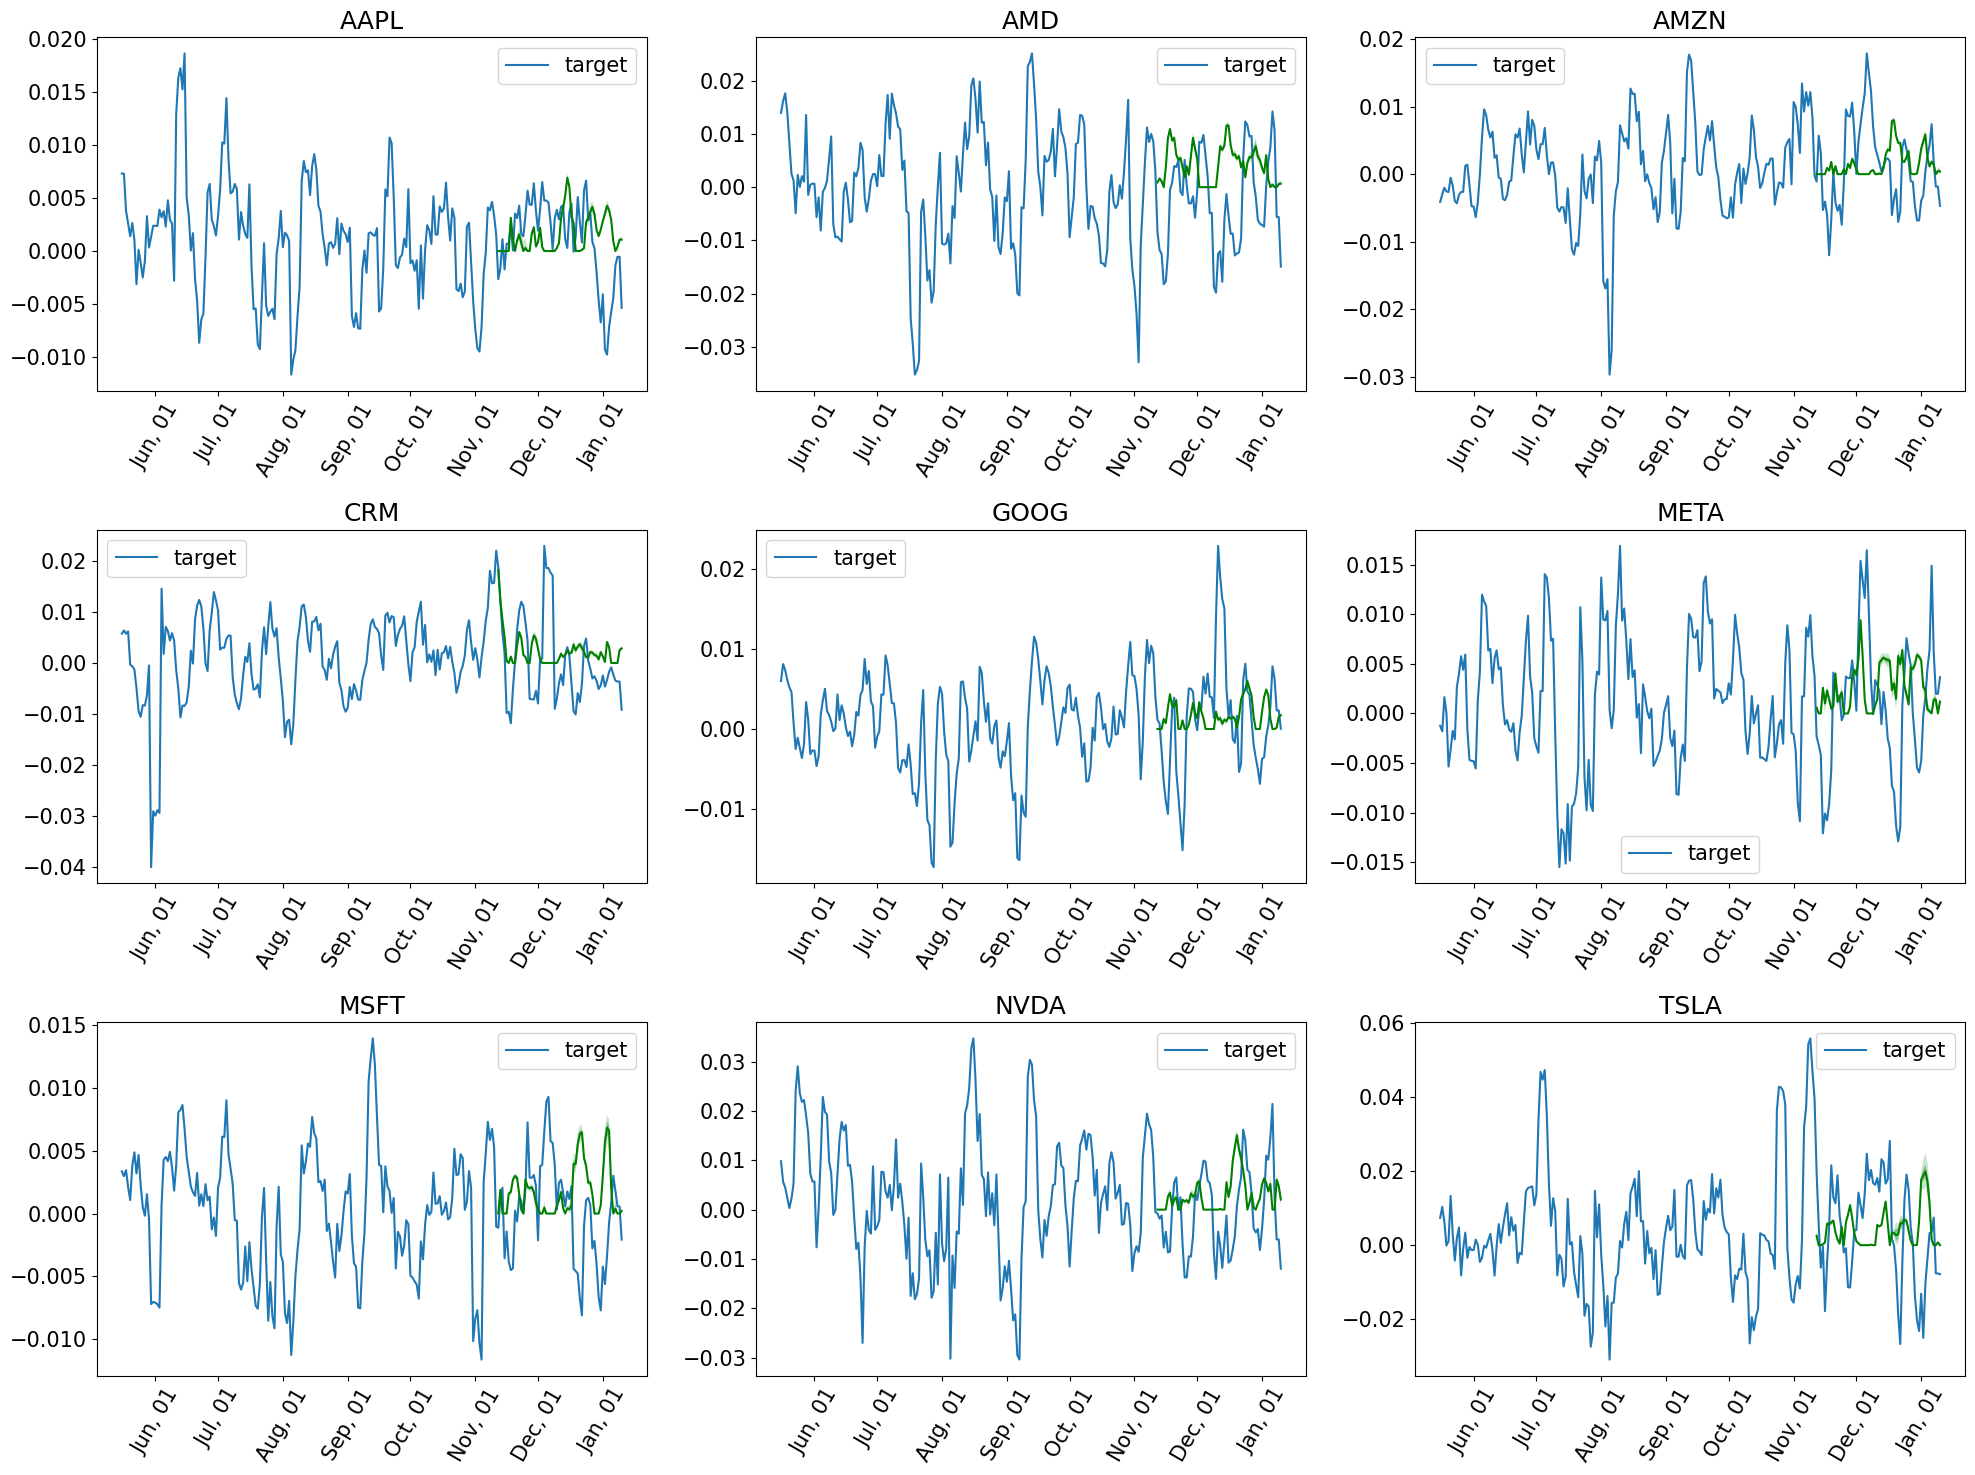

In [7]:


# --- Fine-Tuning ---
# Load pretrained model
ckpt = torch.load("/content/lag-llama/lag-llama.ckpt", map_location="cuda")
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

# Define fine-tuning estimator
estimator = LagLlamaEstimator(
    ckpt_path="/content/lag-llama/lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=32,
    nonnegative_pred_samples=True,
    aug_prob=0,
    lr=5e-4,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    time_feat=estimator_args["time_feat"],
    batch_size=64,
    num_parallel_samples=num_samples,
    trainer_kwargs={
        "max_epochs": 50,
    },
)

# Create training dataset
train_dataset = _get_lag_llama_dataset(stock_returns.iloc[:252*5])

# Train the model
predictor = estimator.train(
    train_dataset,
    cache_data=True,
    shuffle_buffer_length=1000,
)

# Get fine-tuned predictions
forecasts_tuned, tss_tuned = _get_lag_llama_predictions(
    _get_lag_llama_dataset(stock_returns.iloc[252*5:]), prediction_length, num_samples, predictor
)

# Plotting Fine-Tuned Forecasts
plot_forecasts(forecasts_tuned, tss_tuned, prediction_length)